# OUTPUT TRACKING ALGORITHM


---
Author: **Helvecio B. Leal Neto** & **Alan J. P. Calheiros**\
**National Institute for Space Research - Brazil - (2021)**



## About

This notebook is designed for viewing the tracking results of the storm/precipitation tracking algorithm beta version. The results presented here refer to the tracking of clusters via radar data provided by the GoAmazon project, for the following periods:

**Start**: 2014-09-07 00:00:00

**End**: 2014-09-09 00:00:00

The tracking threshold is:

* **20** dBZ
* inner 1 - ***35*** dBZ
* inner 2 - ***40*** dBZ

Minimum size threshold per cluster:

* **30** pixels
* inner 1 - ***15*** pixels
* inner 2 - ***10*** pixels

## Dependencies libraries

In [68]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")
import stanalyzer as sta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
import matplotlib.pyplot as plt # standard graphics library
from matplotlib.colors import LinearSegmentedColormap
import gzip
import netCDF4
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs # cartographic coordinate reference system
import io
from urllib.request import urlopen, Request
from PIL import Image
from math import floor
from matplotlib import patheffects

In [88]:
VAR = 'DBZc'
LEVEL = 5

CPT = sta.cpt_convert.loadCPT('../stanalyzer/cpt/humidity.cpt')
CMAP = LinearSegmentedColormap('cpt', CPT)
VMIN = 0
VMAX = 65

In [202]:
track_frame = sta.read_file('../output/tracking_compressed_new2.pkl')

In [216]:
track_frame.query('time == 20')

,,timestamp,time,uid,id_t,lat,lon,p0,p1,size_20,mean_ref_20,...,trajectory,vector_20,vector_35,vector_40,dsize_20,dmean_ref_20,dtotal_size_35,dmean_total_ref_35,dtotal_size_40,dmean_total_ref_40
Fam_13,155,2014-09-07 04:00:00,20,13,30,-3.759384,-59.145187,86.0,167.0,1052.0,40.238600,...,LINESTRING (-60.62072372436523 -2.322270631790...,LINESTRING (-60.62072372436523 -2.322270631790...,MULTILINESTRING ((-60.85437393188477 -2.178393...,MULTILINESTRING ((-60.85438537597656 -2.196358...,-109.0,2.111936,19.0,1.699948,49.0,1.098952
Fam_24,153,2014-09-07 04:00:00,20,24,25,-1.729412,-60.584507,199.0,87.0,143.0,23.175764,...,LINESTRING (-58.51511001586914 -3.704745292663...,LINESTRING (-58.51511001586914 -3.704745292663...,GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,64.0,-6.210523,NaN,NaN,NaN,NaN
Fam_29,156,2014-09-07 04:00:00,20,29,33,-2.932678,-58.840061,132.0,184.0,43.0,34.037457,...,LINESTRING (-59.68581008911133 -2.034943342208...,LINESTRING (-59.68581008911133 -2.034943342208...,GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,-7.0,2.325554,-1.0,2.823443,NaN,NaN
Fam_30,154,2014-09-07 04:00:00,20,30,26,-4.837726,-59.955353,26.0,122.0,356.0,27.836647,...,LINESTRING (-61.57480621337891 -3.129729747772...,LINESTRING (-61.57480621337891 -3.129729747772...,GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,-332.0,-4.048042,-47.0,-1.487489,NaN,NaN


In [217]:
## This function returns the duration of events
lifes = sta.life_cicle(track_frame,sort=True)
lifes

,uid,times,begin,end,duration
56,182,51,2014-09-08 14:24:00,2014-09-09 00:24:00,0 days 10:00:00
288,68,31,2014-09-07 17:24:00,2014-09-07 23:24:00,0 days 06:00:00
23,13,30,2014-09-07 01:12:00,2014-09-07 07:00:00,0 days 05:48:00
244,414,28,2014-09-08 06:36:00,2014-09-08 12:00:00,0 days 05:24:00
57,183,27,2014-09-08 14:36:00,2014-09-08 19:48:00,0 days 05:12:00
...,...,...,...,...,...
197,367,2,2014-09-09 10:12:00,2014-09-09 10:24:00,0 days 00:12:00
198,368,2,2014-09-09 10:24:00,2014-09-09 10:36:00,0 days 00:12:00
199,369,2,2014-09-09 10:36:00,2014-09-09 10:48:00,0 days 00:12:00
201,370,2,2014-09-09 10:48:00,2014-09-09 11:00:00,0 days 00:12:00


In [239]:
### Filter by time
TIME_MIN = 0
TIME_MAX = 100
UNIT = 'h'

In [240]:
## Apply filter by time
df_filter1 = sta.time_filter(track_frame,TIME_MIN,TIME_MAX,UNIT)

In [241]:
sta.life_cicle(df_filter1,sort=True)

,uid,times,begin,end,duration
56,182,51,2014-09-08 14:24:00,2014-09-09 00:24:00,0 days 10:00:00
288,68,31,2014-09-07 17:24:00,2014-09-07 23:24:00,0 days 06:00:00
23,13,30,2014-09-07 01:12:00,2014-09-07 07:00:00,0 days 05:48:00
244,414,28,2014-09-08 06:36:00,2014-09-08 12:00:00,0 days 05:24:00
57,183,27,2014-09-08 14:36:00,2014-09-08 19:48:00,0 days 05:12:00
...,...,...,...,...,...
197,367,2,2014-09-09 10:12:00,2014-09-09 10:24:00,0 days 00:12:00
198,368,2,2014-09-09 10:24:00,2014-09-09 10:36:00,0 days 00:12:00
199,369,2,2014-09-09 10:36:00,2014-09-09 10:48:00,0 days 00:12:00
201,370,2,2014-09-09 10:48:00,2014-09-09 11:00:00,0 days 00:12:00


In [242]:
fam_test = df_filter1.query('uid == 118')

In [243]:
fam_test.head()

timestamp  time  uid  id_t       lat        lon     p0  \
Fam_118 601  2014-09-07 19:48:00    99  118    23 -3.328352 -60.639290  110.0   
        743  2014-09-07 22:00:00   110  118    13 -3.957147 -60.657730   75.0   
        790  2014-09-07 23:36:00   118  118     5 -4.460242 -60.586048   47.0   
        785  2014-09-07 23:24:00   117  118     5 -4.298570 -60.549900   56.0   
        781  2014-09-07 23:12:00   116  118     6 -4.244661 -60.567879   59.0   

               p1  size_20  mean_ref_20  ...  \
Fam_118 601  84.0    115.0    42.540183  ...   
        743  83.0     64.0    22.195404  ...   
        790  87.0     80.0    22.144835  ...   
        785  89.0    233.0    23.955956  ...   
        781  88.0    377.0    28.503227  ...   

                                                    trajectory  \
Fam_118 601  LINESTRING (-59.7392578125 -4.065142154693604,...   
        743  LINESTRING (-60.74765014648438 -3.813354253768...   
        790  LINESTRING (-61.14364242553711 -3.705176830291...   
        785  LINESTRING (-61.08965301513672 -3.723203659057...   
        781  LINESTRING (-61.05364608764648 -3.723242998123...   

                                                     vector_20  \
Fam_118 601  LINESTRING (-60.13545227050781 -3.795670270919...   
        743  LINESTRING (-60.74765014648438 -3.813354253768...   
        790  LINESTRING (-61.14364242553711 -3.705176830291...   
        785  LINESTRING (-61.08965301513672 -3.723203659057...   
        781  LINESTRING (-61.05364608764648 -3.723242998123...   

                            vector_35                 vector_40  dsize_20  \
Fam_118 601  GEOMETRYCOLLECTION EMPTY  GEOMETRYCOLLECTION EMPTY       NaN   
        743  GEOMETRYCOLLECTION EMPTY  GEOMETRYCOLLECTION EMPTY     -51.0   
        790  GEOMETRYCOLLECTION EMPTY  GEOMETRYCOLLECTION EMPTY      16.0   
        785  GEOMETRYCOLLECTION EMPTY  GEOMETRYCOLLECTION EMPTY     153.0   
        781  GEOMETRYCOLLECTION EMPTY  GEOMETRYCOLLECTION EMPTY     144.0   

             dmean_ref_20  dtotal_size_35  dmean_total_ref_35  dtotal_size_40  \
Fam_118 601           NaN             NaN                 NaN             NaN   
        743    -20.344779             NaN                 NaN             NaN   
        790     -0.050569             NaN                 NaN             NaN   
        785      1.811121             NaN                 NaN             NaN   
        781      4.547272             NaN                 NaN             NaN   

             dmean_total_ref_40  
Fam_118 601                 NaN  
        743                 NaN  
        790                 NaN  
        785                 NaN  
        781                 NaN  

[5 rows x 43 columns]

In [244]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def open_ncdf(nc_file):
    ## OPEN RADAR DATA COMPRESS
    with gzip.open(nc_file) as gz:
        with netCDF4.Dataset('dummy', mode='r', memory=gz.read()) as nc:
            data = nc.variables[VAR][0][LEVEL][:].filled()
            extent = [nc.variables['lon0'][:].min(),nc.variables['lon0'][:].max(),nc.variables['lat0'][:].min(),nc.variables['lat0'][:].max()]
    return data,extent

## Image
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

## Scale bar
def scale_bar(ax, proj, length, location=(0.5, 0.05), linewidth=3,
              units='km', m_per_unit=1000):
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, fontsize=14, zorder=4)
    left = x0+(x1-x0)*(0.9)
    # Plot the N arrow
    t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, fontsize=14, zorder=4)
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, zorder=6)

def utm_from_lon(lon):
    return floor( ( lon + 180 ) / 6) + 1 

In [245]:
def plot(dframe,t = 0):
    
    ## GET TIMESTAMP LIST
    time_list = [np.unique(sorted(dframe.time))[t]]
    locked_by_time = dframe.query('time <= @time_list')

    geo_cols = []
    list_cols = locked_by_time.columns.to_list()
    tresholds = []
    for c in list_cols:
        if 'geom_' in c or 'line' in c or 'traj' in c or 'vect' in c:
            geo_cols.append(c)
        if 'geom_' in c and 'geom_i' not in c:
            tresholds.append(int(c[-2:]))
            
    geo_cols = sorted(geo_cols)
    
    no_geo_cols = [item for item in list_cols if item not in geo_cols]
    ### CREATE GEODATAFRAME
    geo_frame = gpd.GeoDataFrame(locked_by_time[no_geo_cols])

    ### OPEN MATRIX
    nc_file = locked_by_time.loc[locked_by_time['time'] == time_list[-1]]['nc_file'].unique()[0]
    data,extent = open_ncdf(nc_file)
    ## FILTER
    data[data <= 0 ] = np.nan
    
    ## FIGURE
    cimgt.Stamen.get_image = image_spoof # reformat web request for street map spoofing
    osm_img = cimgt.Stamen('terrain-background'); # spoofed, downloaded street map
    
    plt.figure(figsize=(10,10),dpi=100)
    ax = plt.axes(projection = osm_img.crs)
    ax.set_extent(extent)
    
    ### BACKGROUND
    zoom = 1
    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    scale = (scale<20) and scale or 19 # scale cannot be larger than 19
    ax.add_image(osm_img, int(scale)) # add OSM with zoom specification
    
    color_range = ['red','C1','C2','C3','C4','C5']
    
    for g in range(len(geo_cols)):
        
        ## Plot Geometries
        if 'geom_' in geo_cols[g] and 'geom_i' not in geo_cols[g]:
            last_time = time_list[-1]
            last_series = locked_by_time.query('time == @last_time')[geo_cols[g]].apply(wkt.loads)
            geo_frame['geometry'] = last_series
            geo_frame.exterior.plot(ax=ax,color=color_range[g],linewidth=1,label=geo_cols[g],transform = ccrs.PlateCarree())
          
        ## Plot Trajectory
        if 'traj' in geo_cols[g]:
            lock_uids = locked_by_time.query('time == @last_time').uid.values.tolist()           
            traject = locked_by_time.query('uid == @lock_uids')[geo_cols[g]].apply(wkt.loads)
            geo_frame['geometry'] = traject
            geo_frame.plot(ax=ax,color='black',label=geo_cols[g],transform = ccrs.PlateCarree())
            
        ## Plot vectores
#         if 'vect' in geo_cols[g]:
#             lock_uids = locked_by_time.query('time == @last_time').uid.values.tolist()           
#             traject = locked_by_time.query('uid == @lock_uids')[geo_cols[g]].apply(wkt.loads)
#             geo_frame['geometry'] = traject
#             geo_frame.plot(ax=ax,color='gray',label=geo_cols[g])
    
    #### PLOT DATA
    cs = ax.contourf(data, cmap = CMAP, vmin = VMIN, vmax = VMAX, extent = extent,alpha=0.9, transform = ccrs.PlateCarree())
    
    ### LINES LABELS
    gl = ax.gridlines( draw_labels=True,
              linewidth=1, color='gray', alpha=0.5, linestyle='--') # label all axes
    gl.top_labels = False # turn off top label
    gl.right_labels = False # turn off right label
    
    ## PLOT SCALE BAR
    scale_bar(ax, ccrs.Mercator(), 50)
    ## COLOR BAR
    sm = plt.cm.ScalarMappable(cmap=CMAP,norm=plt.Normalize(VMIN,VMAX))
    sm._A = []
    cbar = plt.colorbar(sm,ax=ax,extend='both',pad=0.05,shrink=0.6,orientation='horizontal')
    cbar.set_label('Refletividade (dBZ)')
    
    ## LEGEND
    ax.legend()

In [246]:
df_filter1.query('time == 20')

,,timestamp,time,uid,id_t,lat,lon,p0,p1,size_20,mean_ref_20,...,trajectory,vector_20,vector_35,vector_40,dsize_20,dmean_ref_20,dtotal_size_35,dmean_total_ref_35,dtotal_size_40,dmean_total_ref_40
Fam_13,155,2014-09-07 04:00:00,20,13,30,-3.759384,-59.145187,86.0,167.0,1052.0,40.238600,...,LINESTRING (-60.62072372436523 -2.322270631790...,LINESTRING (-60.62072372436523 -2.322270631790...,MULTILINESTRING ((-60.85437393188477 -2.178393...,MULTILINESTRING ((-60.85438537597656 -2.196358...,-109.0,2.111936,19.0,1.699948,49.0,1.098952
Fam_24,153,2014-09-07 04:00:00,20,24,25,-1.729412,-60.584507,199.0,87.0,143.0,23.175764,...,LINESTRING (-58.51511001586914 -3.704745292663...,LINESTRING (-58.51511001586914 -3.704745292663...,GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,64.0,-6.210523,NaN,NaN,NaN,NaN
Fam_29,156,2014-09-07 04:00:00,20,29,33,-2.932678,-58.840061,132.0,184.0,43.0,34.037457,...,LINESTRING (-59.68581008911133 -2.034943342208...,LINESTRING (-59.68581008911133 -2.034943342208...,GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,-7.0,2.325554,-1.0,2.823443,NaN,NaN
Fam_30,154,2014-09-07 04:00:00,20,30,26,-4.837726,-59.955353,26.0,122.0,356.0,27.836647,...,LINESTRING (-61.57480621337891 -3.129729747772...,LINESTRING (-61.57480621337891 -3.129729747772...,GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,-332.0,-4.048042,-47.0,-1.487489,NaN,NaN


/home/helvecioneto/miniconda3/envs/stanalyzer/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:762: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f30695b7290> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


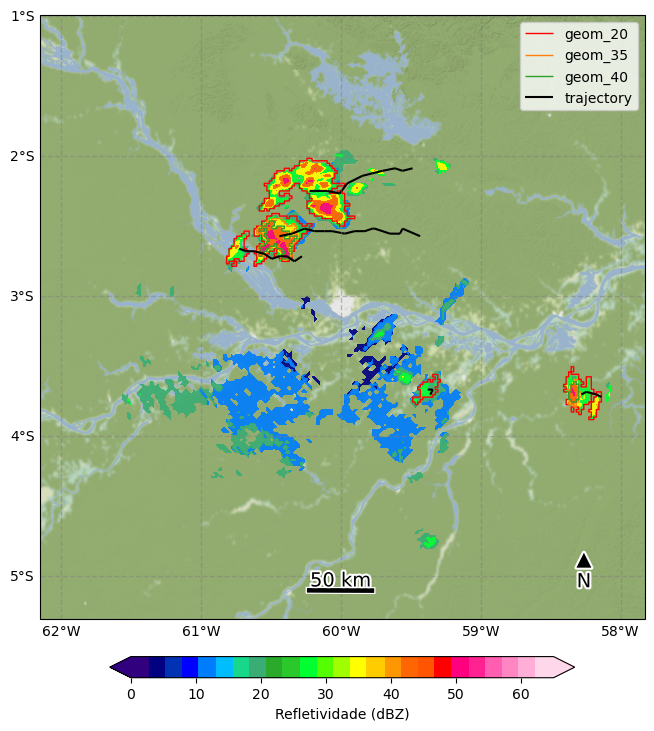

In [247]:
plot(df_filter1,14)

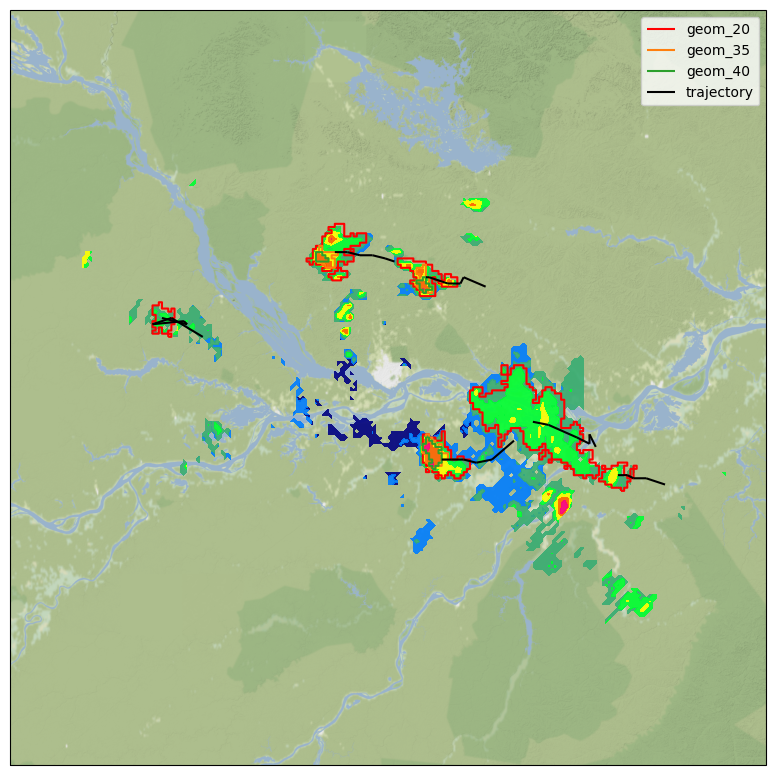

In [145]:
plot(df_filter1,5)

In [38]:
open_ncdf(df_filter1['nc_file'].iloc[0])

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 [-62.156124, -57.826694, -5.3048506, -0.99121743])

In [188]:
from shapely import wkt
import numpy as np

In [198]:
fam_test = df_filter1.query('uid == 118')
fam_test['geom_35'].fillna(value='GEOMETRYCOLLECTION EMPTY', inplace=True)


geo_frame = gpd.GeoDataFrame()
geo_frame['geometry'] = fam_test['geom_35'].apply(wkt.loads)

<AxesSubplot:>

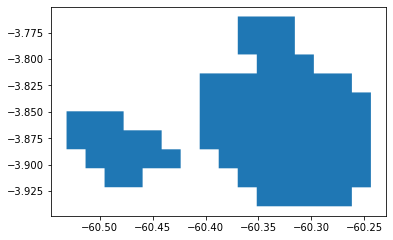

In [210]:
geo_frame.tail(2).plot()

In [162]:
fam_test['geom_35'].apply(wkt.loads)

TypeError: Only str is accepted.

In [40]:
tt = gpd.GeoDataFrame()
tt['geometry'] = fam_test['geom_intersect'].apply(wkt.loads)

<AxesSubplot:>

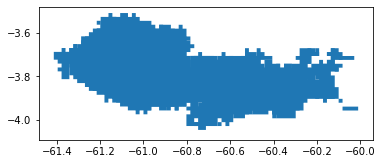

In [41]:
tt.plot()

In [13]:
import geopandas as gpd

In [ ]:
### PATH
PATH_FILE = '../tracks/S201409070000_E201409100000_VDBZc_T20_L5.pkl'

In [ ]:
### Read tracking file
df = sta.read_file(PATH_FILE)
df.head()

In [ ]:
sta.life_cicle()

In [ ]:
life_cicle(df)

In [ ]:
# Dataframe library
import pandas as pd
# Numerical Python library
import numpy as np
# netCDF4 library
import netCDF4
# Import gzip to open netCDF
import gzip
# Visualization library
import matplotlib.pyplot as plt

## Variables

**Fam_Nº**-> Refers to the number of the Tracked Family.
<br>

**timestamp** ->A digital record of the time of occurrence of a particular event.
<br>
**time** -> Refers to the tracking time in the algorithm.
<br>
**uid** -> Unique IDentifier, it is used to generate the families.
<br>
**id_t** -> Referring cluster identifier at the time of tracking occurrence. From the DBSCAN clustering algorithm.
<br>
**lat** -> Refers latitude centroid, taken from the reference matrix of the original nc files.
<br>
**lon** -> Refers longitude centroid, taken from the reference matrix of the original nc files.
<br>
**p0** -> The first coordinate point of centroid in matrix (clusters or nc_file): (p0,p1)=(x,y)=(lon,lat).
<br>
**p1** -> The second coordinate point of centroid in matrix (clusters or nc_file): (p0,p1)=(x,y)=(lon,lat).
<br>
**size_%THRESHOLD** -> Total number of Pixels in the main cluster. Each point depends on the sensor's spatial resolution (pixel size): RADAR 2x2km.
<br>
**mean_ref_%THRESHOLD** -> Averaged reflectivity of the cluster. Value in dBZ.
<br>
**max_ref_%THRESHOLD** -> Max reflectivity of the cluster. Value in dBZ.
<br>
**angle_%THRESHOLD_orig** -> Original displacement angle of the cluster at the current time.
<br>
**angle_%THRESHOLD_cor** -> Corrected displacement angle of the cluster at the current time. 
<br>
**vel_%THRESHOLD_orig** -> Original displacement velocity of the cluster at the current time in kilometers per hour (km/h).
<br>
**vel_%THRESHOLD_cor** -> Corrected displacement velocity of the cluster at the current time in kilometers per hour (km/h).
<br>
**mean_total_ref_%THRESHOLD** -> Average reflectivity of the inner clusters by threshold (Value in dBZ).
<br>
**total_size_%THRESHOLD** -> Total size of inner clusters by threshold (number of pixels).
<br>
**n_cluster_%THRESHOLD** -> Total number of inner clusters by Threshold.
<br>
**avg_angle_%THRESHOLD** -> Averaged angle for the inner cluster by threshold (Value in degree).
<br>
**avg_vel_%THRESHOLD** -> Averaged velocity for inner clusters by threshold (Value in km/h).
<br>
**status** -> Status of occurrence, type: NEW-> New cluster; CONT-> Continous cluster; SPLT -> Splitted cluster; MERG -> Merged Cluster.
<br>
**delta_t** -> Time interval for cluster life cycle.
<br>
**nc_file** -> Path of netCDF file.
<br>
**cluster_file** -> Path of cluster file (From DBSCAN).
<br>
**dsize_%THRESHOLD** -> Difference between the sizes of two consecutive clusters (in Pixel).
<br>
**dmean_ref_%THRESHOLD** -> Difference between the mean reflectivities of two consecutive clusters for main threshold (in dBZ).
<br>
**dmean_total_ref_%THRESHOLD** -> Difference between the mean reflectivities of all clusters between two consecutive times for an inner threshold (in dBZ).
<br>
**dtotal_size_%THRESHOLD** -> Difference between the total size (in pixel) of all clusters between two consecutive times for an inner threshold (values in pixel).

## Read tracking file

Tracking DataFrame.

In [ ]:
fam_tracking = pd.read_pickle("./S201409070000_E201409100000_VDBZc_T20_L5.pkl")
fam_tracking

### Example how to select a FAM by uid

In [ ]:
uid = 97
selected_fam = fam_tracking.query('uid == @uid')
selected_fam

## Example how to select a cluster in the family

In [ ]:
line = 0 #first line 

selected_line = selected_fam.iloc[[line]]
selected_line

## Example how to open the cluster file and the original data to extract reflectivity values

In [ ]:
## OPEN CLUSTERS
def open_cluster(path):
    try:
        cluster = np.load(path['cluster_file'].values[0])['arr_0']
        cluster[cluster == 0] = np.NAN
        return cluster
    except:
        print('File not found!')

In [ ]:
selected_line

In [ ]:
cluster_matrix_all = open_cluster(selected_line)
print('Original dimensions of cluster->',cluster_matrix_all.shape)

THRESHOLD_LEVEL = 0 #to select the main threshold (ex: 0-20dBZ,1-35dBZ,2-40dBZ)
cluster_matrix = cluster_matrix_all[:,:,THRESHOLD_LEVEL]
print('Selected dimensions of cluster->',cluster_matrix.shape)

In [ ]:
### OPEN NETCDF
def open_file(file_path):
    VAR_NAME = 'DBZc'
    LEVEL = 5 #2.5km height
    THRESHOLDS = [20,35,40] #dBZ
    with gzip.open(file_path['nc_file'].values[0]) as gz:
        with netCDF4.Dataset('dummy', mode='r', memory=gz.read()) as nc:
            data = nc.variables[VAR_NAME][0][LEVEL][:].filled()
            data[data == -9999.] = np.NAN
    data[data < THRESHOLDS[0]] = np.nan
    return data

In [ ]:
nc_matrix = open_file(selected_line)
print('NetCDF Max/Min values (thresholded):\n',np.nanmax(nc_matrix),np.nanmin(nc_matrix))

In [ ]:
fig, (ax,ax1) = plt.subplots(1,2, figsize=(15,6))

ax.imshow(nc_matrix)
ax1.imshow(cluster_matrix);
ax.set_title('Original file')
ax1.set_title('Cluster file');

## Extracting reflectivities from the selected cluster

To extract the reflectivity values of an individual cluster, you will need to choose the tracking 'id_t', this should be done as follows:

Visualization of individual line.

In [ ]:
selected_line

In [ ]:
### This line shows that id_t is equal to 20. 
selected_id_t = selected_line.id_t.values[0]

### Get XY coordinates from cluster matrix
x,y = np.where(cluster_matrix == selected_id_t)

### Get reflectivities values from nc_file cluster
dbz_list = nc_matrix[x,y]

In [ ]:
print('List with reflectivity values of an individual cluster.\n',dbz_list)

### Cluster location view

In [ ]:
fig, (ax,ax1) = plt.subplots(1,2, figsize=(15,6))
ax.imshow(nc_matrix)
ax1.imshow(cluster_matrix);
ax.set_title('Original file')
ax1.set_title('Cluster file');

ax.scatter(selected_line.p0,selected_line.p1,marker='x',color='r',s=100)
ax1.scatter(selected_line.p0,selected_line.p1,marker='x',color='r',s=100)